In [193]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler

from sklearn.impute import SimpleImputer, KNNImputer
#from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import  train_test_split
from sklearn.compose import ColumnTransformer

from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, f1_score, recall_score, precision_score, accuracy_score, ConfusionMatrixDisplay

from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier




In [ ]:
df = pd.read_csv("loan_data_set.csv")
df

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
610,LP002979,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y
611,LP002983,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y
612,LP002984,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [5]:
df.Credit_History.value_counts()

Credit_History
1.0    475
0.0     89
Name: count, dtype: int64

In [6]:
df.Loan_Amount_Term.value_counts()

Loan_Amount_Term
360.0    512
180.0     44
480.0     15
300.0     13
84.0       4
240.0      4
120.0      3
60.0       2
36.0       2
12.0       1
Name: count, dtype: int64

In [195]:
df.drop(columns = ["Loan_ID"], inplace = True)

In [196]:
df = df.astype({"Loan_Amount_Term": "object", "Credit_History": "object"})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             601 non-null    object 
 1   Married            611 non-null    object 
 2   Dependents         599 non-null    object 
 3   Education          614 non-null    object 
 4   Self_Employed      582 non-null    object 
 5   ApplicantIncome    614 non-null    int64  
 6   CoapplicantIncome  614 non-null    float64
 7   LoanAmount         592 non-null    float64
 8   Loan_Amount_Term   600 non-null    object 
 9   Credit_History     564 non-null    object 
 10  Property_Area      614 non-null    object 
 11  Loan_Status        614 non-null    object 
dtypes: float64(2), int64(1), object(9)
memory usage: 57.7+ KB


In [197]:
cat_vars =[]
num_vars =[]
for c in df.columns:
    if df[c].dtype == "float64" or df[c].dtype == "int64":
        num_vars.append(c)
    else:
        cat_vars.append(c)

print(cat_vars)
print(num_vars)

['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status']
['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']


In [10]:
print(len(cat_vars))
print(len(num_vars))

9
3


In [11]:
for c in cat_vars:
    print(df[c].value_counts())
    print("-"*20)


Gender
Male      489
Female    112
Name: count, dtype: int64
--------------------
Married
Yes    398
No     213
Name: count, dtype: int64
--------------------
Dependents
0     345
1     102
2     101
3+     51
Name: count, dtype: int64
--------------------
Education
Graduate        480
Not Graduate    134
Name: count, dtype: int64
--------------------
Self_Employed
No     500
Yes     82
Name: count, dtype: int64
--------------------
Loan_Amount_Term
360.0    512
180.0     44
480.0     15
300.0     13
84.0       4
240.0      4
120.0      3
60.0       2
36.0       2
12.0       1
Name: count, dtype: int64
--------------------
Credit_History
1.0    475
0.0     89
Name: count, dtype: int64
--------------------
Property_Area
Semiurban    233
Urban        202
Rural        179
Name: count, dtype: int64
--------------------
Loan_Status
Y    422
N    192
Name: count, dtype: int64
--------------------


In [12]:
df["Loan_Status"].value_counts()/df.shape[0]

Loan_Status
Y    0.687296
N    0.312704
Name: count, dtype: float64

In [13]:
df.Property_Area.value_counts()

Property_Area
Semiurban    233
Urban        202
Rural        179
Name: count, dtype: int64

In [23]:
dependets_order = pd.CategoricalDtype(["0","1","2","3+"], ordered = True)
df['Dependents'] = df["Dependents"].astype(dependets_order)

term_order = pd.CategoricalDtype([12.0, 36.0, 60.0, 84.0, 120.0, 240.0, 300.0, 360.0, 480.0], ordered = True)
df["Loan_Amount_Term"]= df["Loan_Amount_Term"].astype(term_order)

area_order = pd.CategoricalDtype(["Rural", "Semiurban", "Urban"], ordered= True)
df["Property_Area"]= df["Property_Area"].astype(area_order)



In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Gender             601 non-null    object  
 1   Married            611 non-null    object  
 2   Dependents         599 non-null    category
 3   Education          614 non-null    object  
 4   Self_Employed      582 non-null    object  
 5   ApplicantIncome    614 non-null    int64   
 6   CoapplicantIncome  614 non-null    float64 
 7   LoanAmount         592 non-null    float64 
 8   Loan_Amount_Term   556 non-null    category
 9   Credit_History     564 non-null    object  
 10  Property_Area      614 non-null    category
 11  Loan_Status        614 non-null    object  
dtypes: category(3), float64(2), int64(1), object(6)
memory usage: 45.8+ KB


In [17]:
df

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...
609,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
610,Male,Yes,3+,Graduate,No,4106,0.0,40.0,NaN,1.0,Rural,Y
611,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y
612,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y


## Visualization

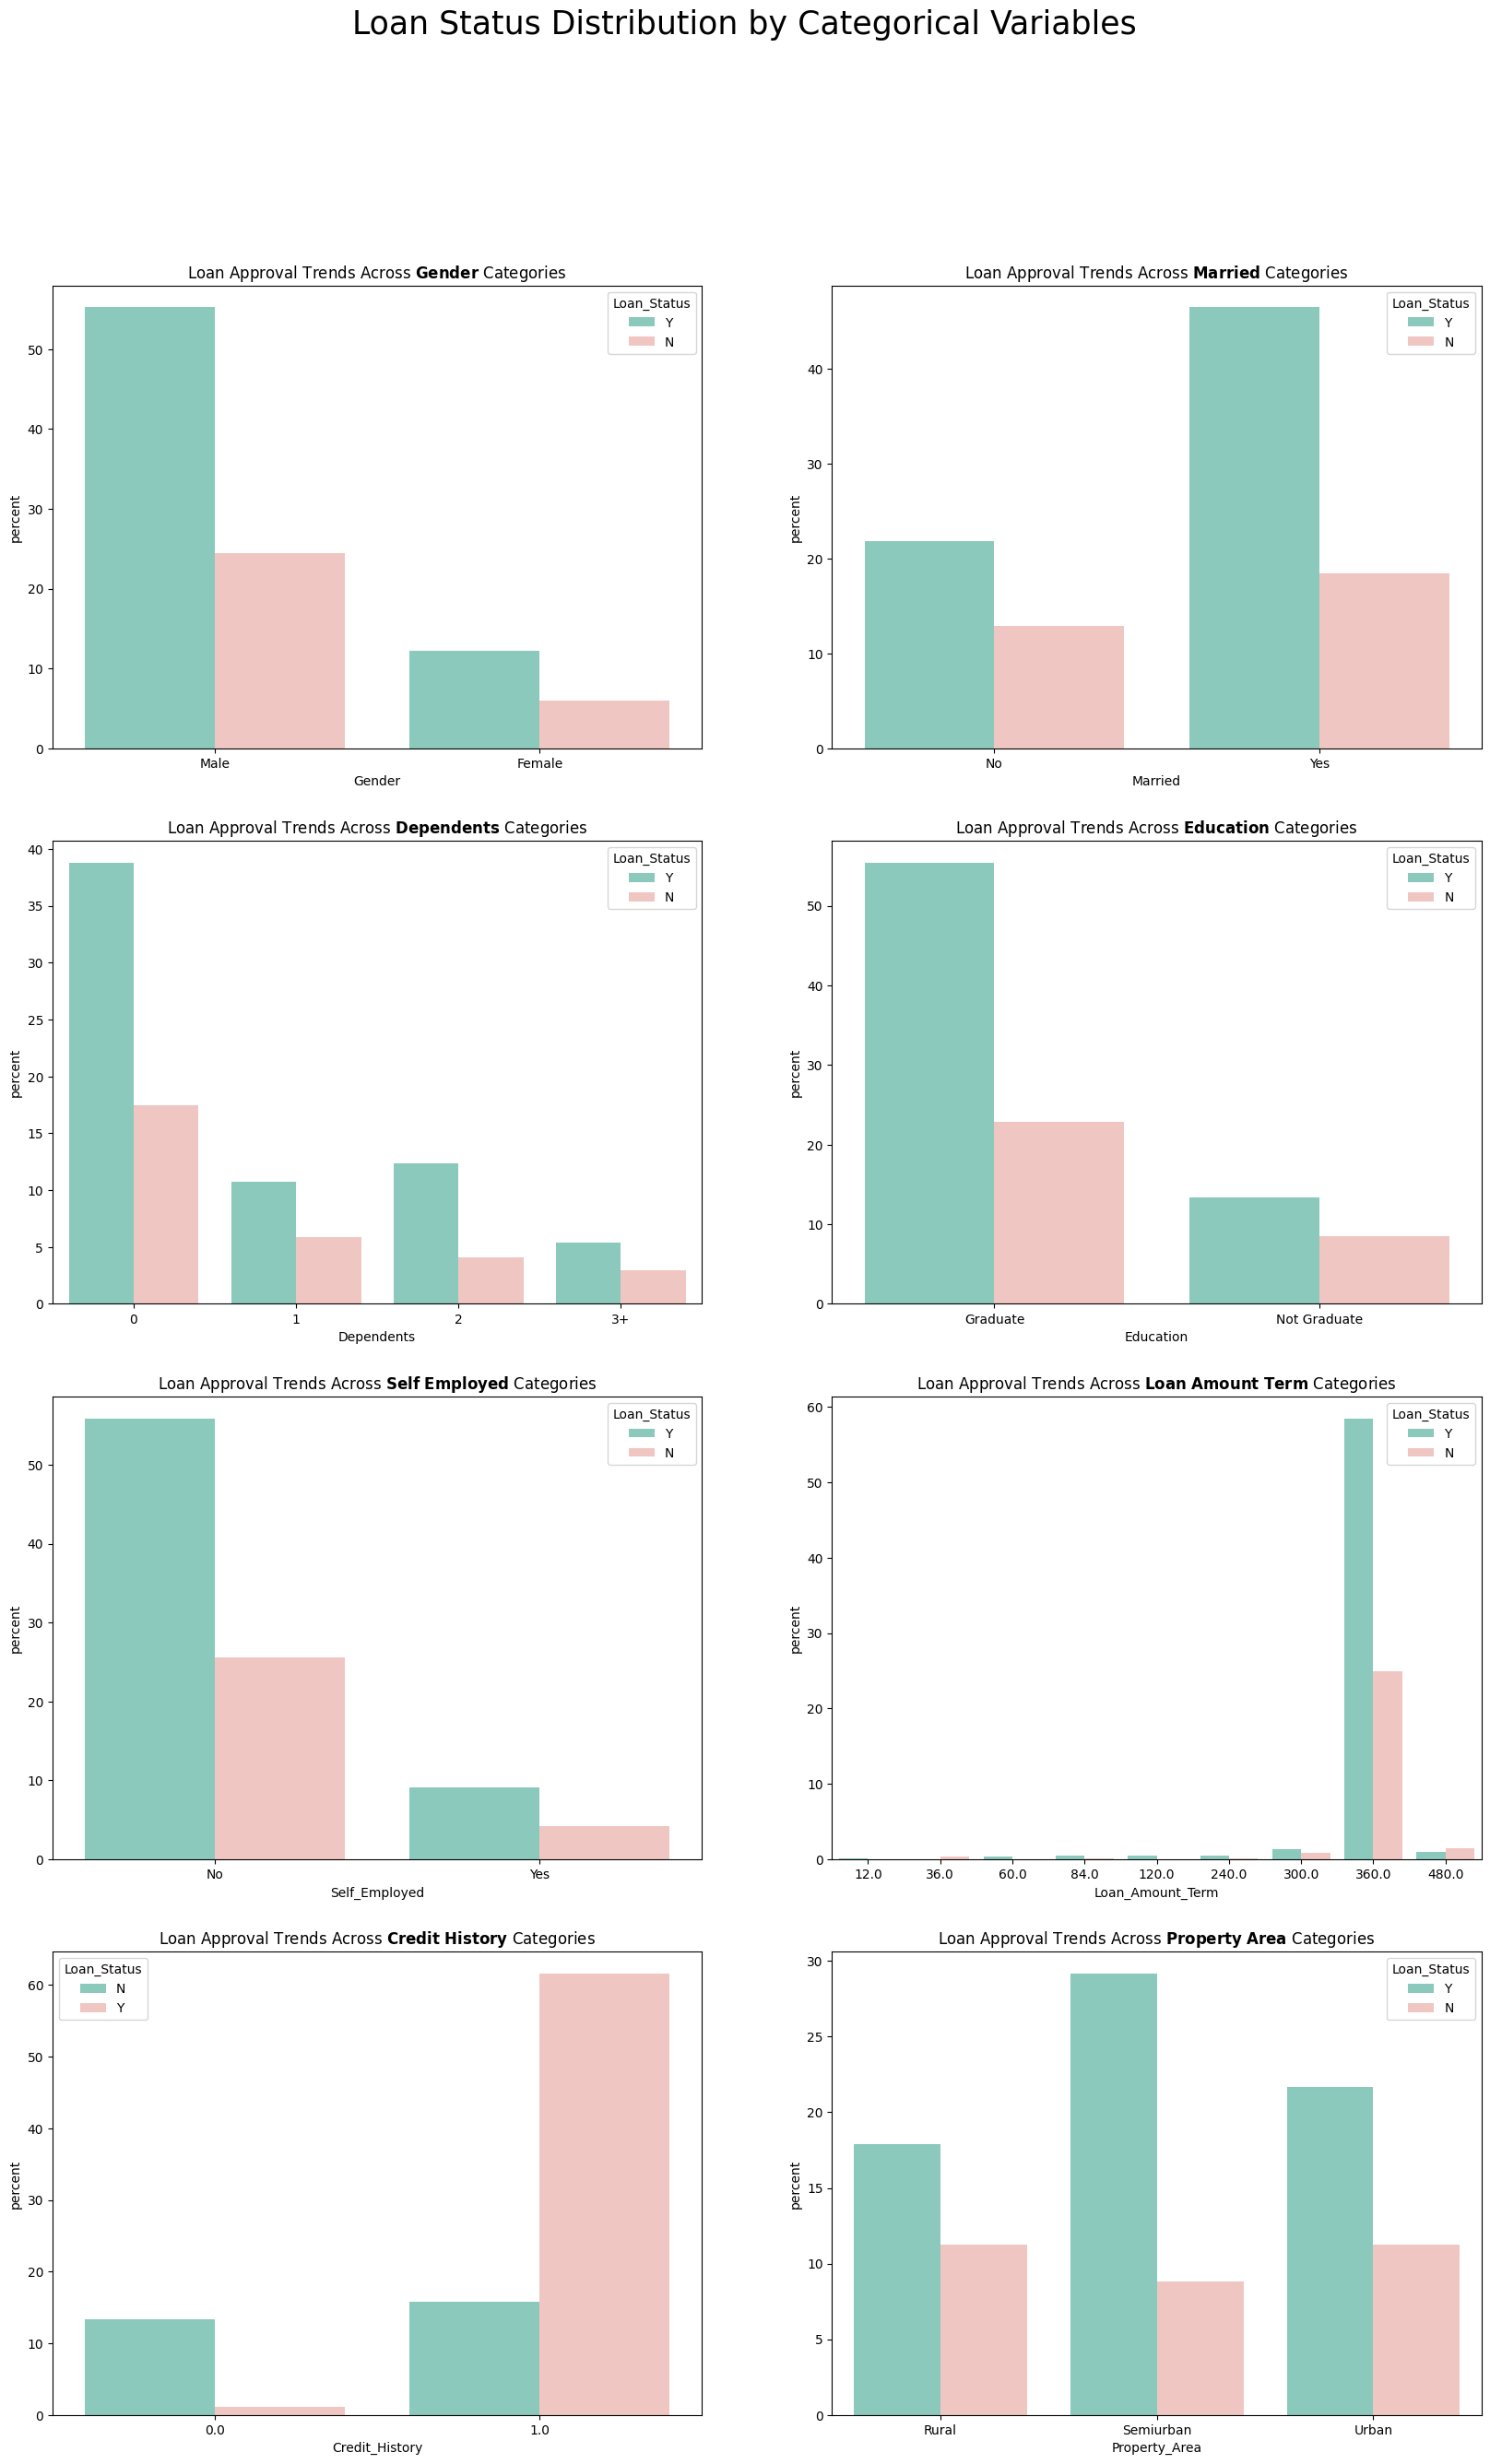

In [18]:
fig,ax = plt.subplots(4,2, figsize = (20,30))
fig.suptitle("Loan Status Distribution by Categorical Variables", fontsize = 25)
custom_palette = ['#7FD4C1','#F7C0BB',]#'#4CAF50', '#FF5722']

for i, cat_feature in enumerate(cat_vars[:-1]):
    sns.countplot(data = df , x = cat_feature, hue = "Loan_Status", stat = "percent", ax = ax[i//2, i%2], color = 'group', palette=custom_palette)
    cat_feature = cat_feature.replace('_', '\\ ')
    ax[i//2,i%2].set_title(f"Loan Approval Trends Across $\\bf{{{cat_feature}}}$ Categories" , fontsize=12, fontweight='normal')


C:\Users\solmaz\AppData\Local\Temp\ipykernel_11204\1970870958.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x="Loan_Status", y=feature, ax=ax[i//2, i%2], palette=custom_palette)
C:\Users\solmaz\AppData\Local\Temp\ipykernel_11204\1970870958.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x="Loan_Status", y=feature, ax=ax[i//2, i%2], palette=custom_palette)
C:\Users\solmaz\AppData\Local\Temp\ipykernel_11204\1970870958.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x="Loan_Status", y=feature, ax=ax[i//2

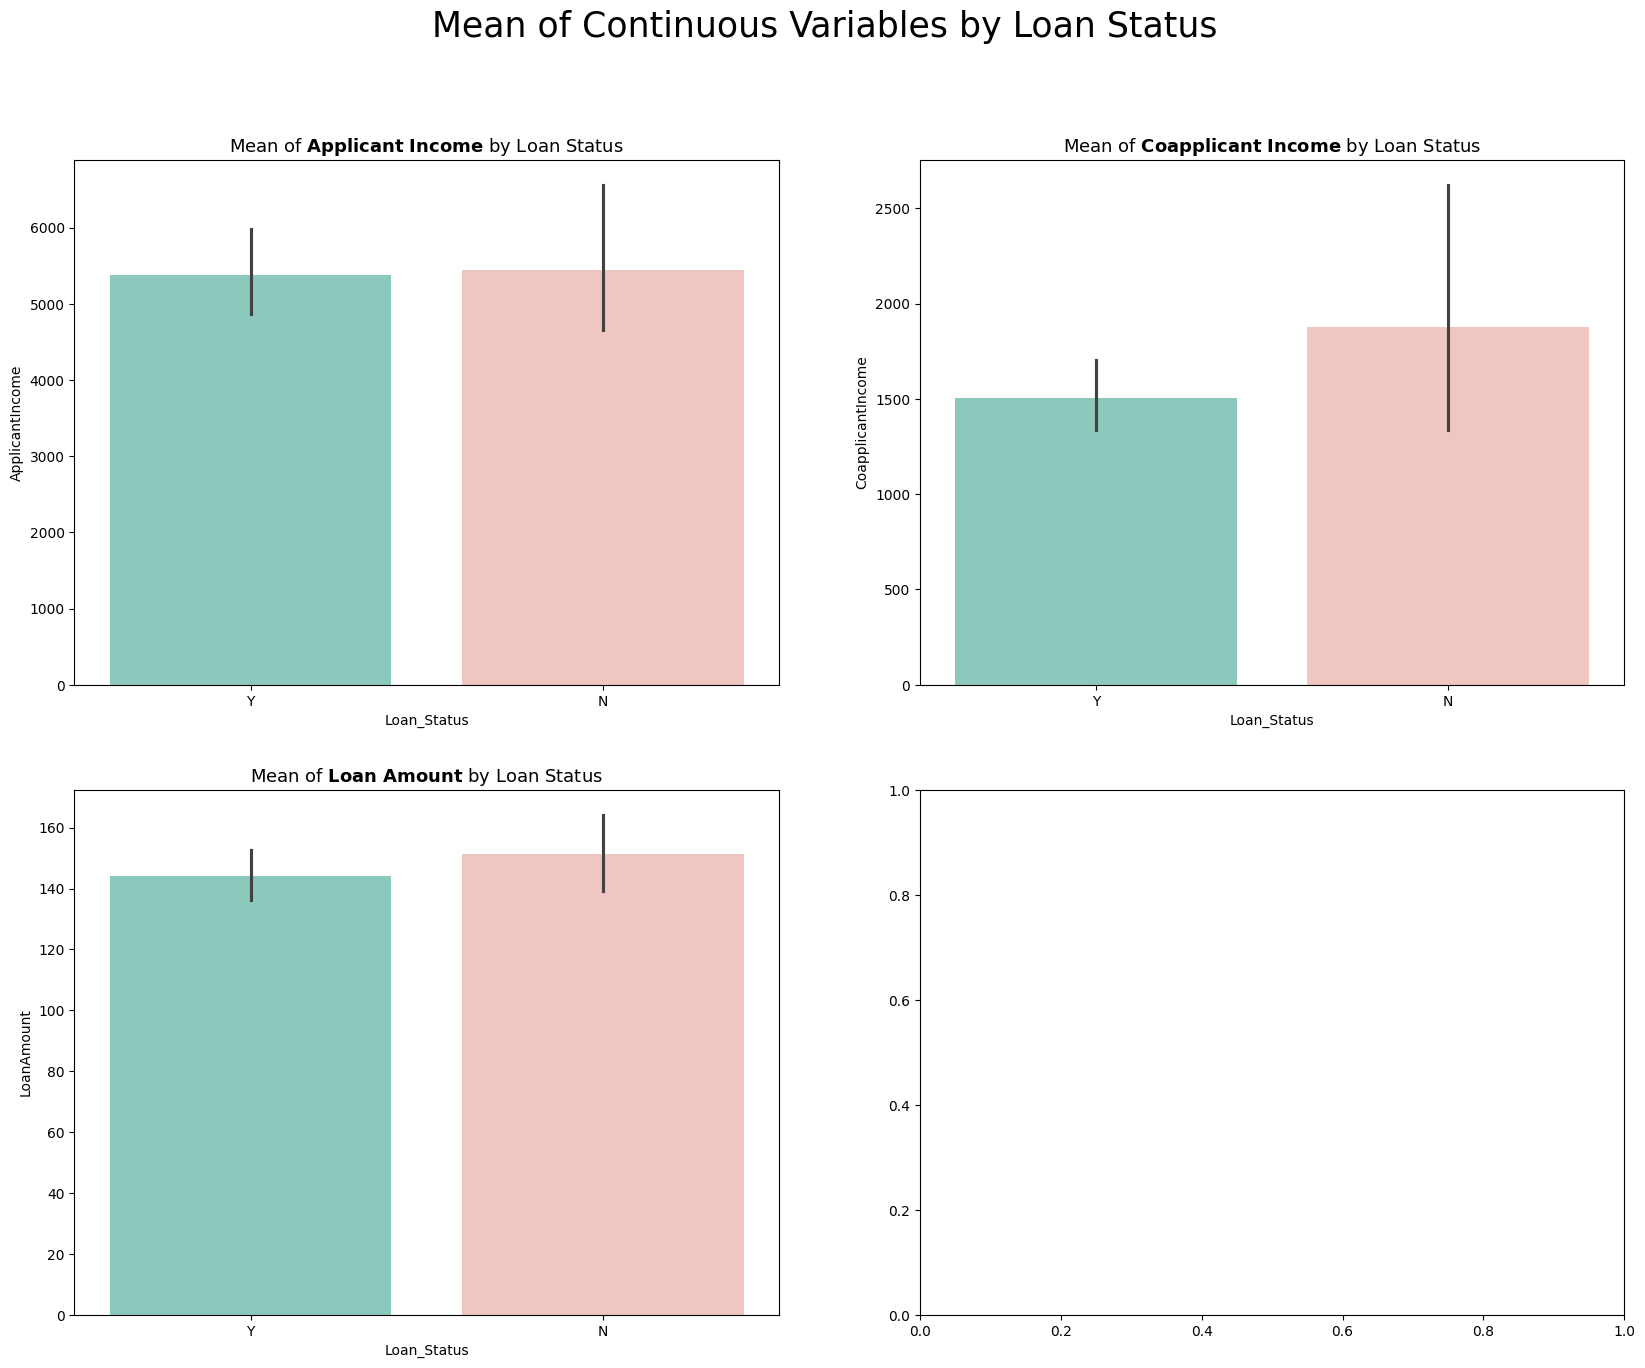

In [14]:

custom_palette = ['#7FD4C1','#F7C0BB'] 

fig, ax = plt.subplots(2, 2, figsize=(20, 15))
fig.suptitle("Mean of Continuous Variables by Loan Status", fontsize=25)

for i, feature in enumerate(num_vars):
    sns.barplot(data=df, x="Loan_Status", y=feature, ax=ax[i//2, i%2], palette=custom_palette)
    
    feature = re.sub(r'(?<!^)(?=[A-Z])', '\\ ', feature)
    feature = feature.replace('_', ' ')
    
    ax[i//2, i%2].set_title(f"Mean of $\\bf{{{feature}}}$ by Loan Status", fontsize=13)


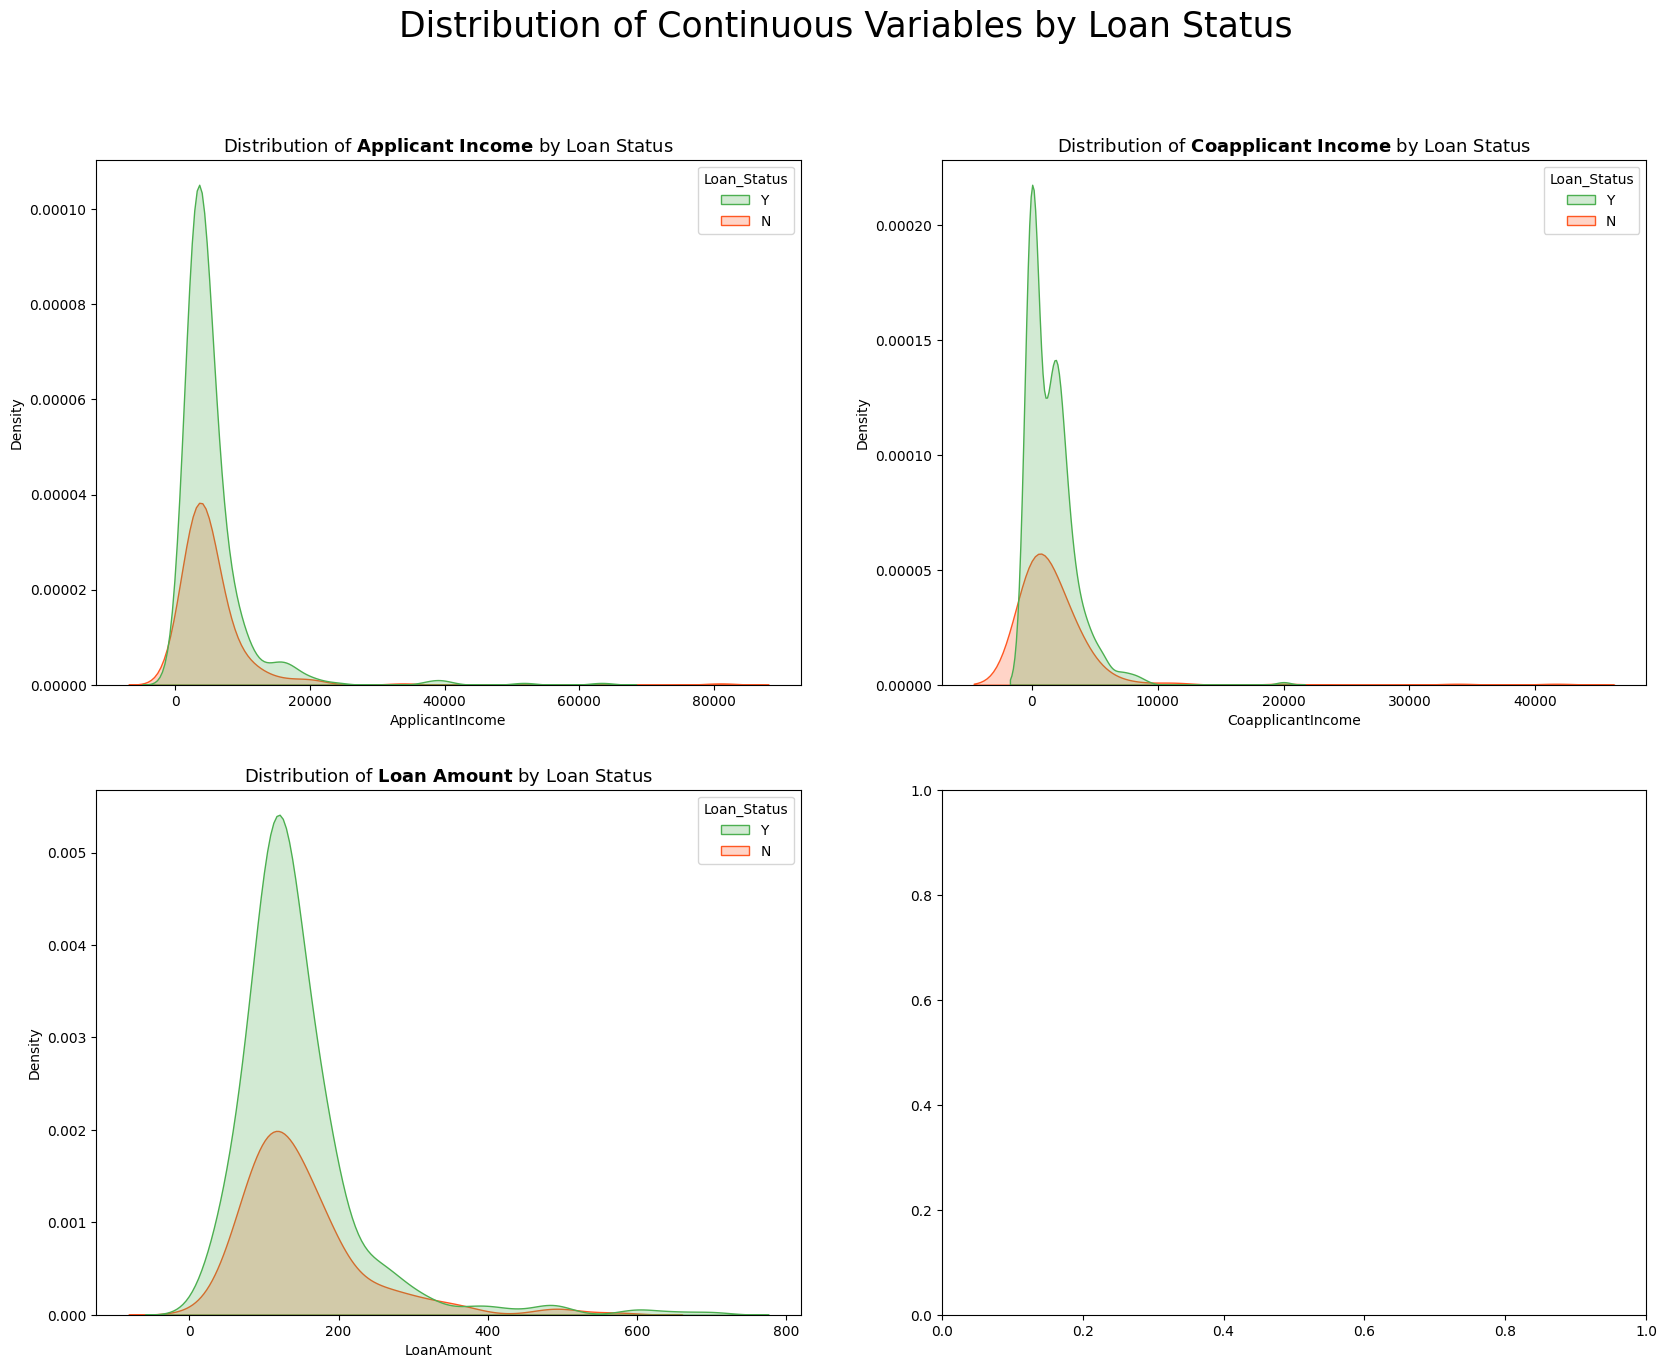

In [15]:
custom_palette = ['#4CAF50', '#FF5722']  # 'A': '#7FD4C1', 'B': '#30BFDD', 'C': '#8690FF', 'E': '#F7C0BB'

fig, ax = plt.subplots(2, 2, figsize=(20, 15))
fig.suptitle("Distribution of Continuous Variables by Loan Status", fontsize=25)

for i, feature in enumerate(num_vars):
    sns.kdeplot(data=df, hue="Loan_Status",fill= True, x=feature, ax=ax[i//2, i%2], palette=custom_palette)
    
    feature = re.sub(r'(?<!^)(?=[A-Z])', '\\ ', feature)
    feature = feature.replace('_', ' ')
    
    ax[i//2, i%2].set_title(f"Distribution of $\\bf{{{feature}}}$ by Loan Status", fontsize=13)

# Handling missing values

In [16]:
sum(df["Gender"].isnull())/df.shape[0]


for f in df.columns:
    print(f"Percent of missing values in {f}:", (sum(df[f].isnull())/df.shape[0])*100)

Percent of missing values in Gender: 2.1172638436482085
Percent of missing values in Married: 0.4885993485342019
Percent of missing values in Dependents: 2.44299674267101
Percent of missing values in Education: 0.0
Percent of missing values in Self_Employed: 5.211726384364821
Percent of missing values in ApplicantIncome: 0.0
Percent of missing values in CoapplicantIncome: 0.0
Percent of missing values in LoanAmount: 3.5830618892508146
Percent of missing values in Loan_Amount_Term: 9.446254071661238
Percent of missing values in Credit_History: 8.143322475570033
Percent of missing values in Property_Area: 0.0
Percent of missing values in Loan_Status: 0.0


In [ ]:
# missing_imp_cat = SimpleImputer( strategy= "most_frequent")
# missing_imp_mean_num = SimpleImputer(strategy = "mean")

# cat_imputed_values = missing_imp_cat.fit_transform(df[["Gender", "Married", "Dependents", "Self_Employed", "Loan_Amount_Term", "Credit_History"]])
# loan_amount_imputed = missing_imp_mean_num.fit_transform(df["LoanAmount"].values.reshape(-1,1))



In [ ]:
# df_cat_imputed = pd.DataFrame(cat_imputed_values, columns=["Gender", "Married", "Dependents", "Self_Employed", "Loan_Amount_Term", "Credit_History"])
# df_loan_amount_imputed = pd.DataFrame(loan_amount_imputed, columns = ["LoanAmount"])

# df = pd.concat([df_cat_imputed, df_loan_amount_imputed,df[["Education","ApplicantIncome", "CoapplicantIncome", "Property_Area", "Loan_Status"]]], axis = 1)
# df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             614 non-null    object 
 1   Married            614 non-null    object 
 2   Dependents         614 non-null    object 
 3   Self_Employed      614 non-null    object 
 4   Loan_Amount_Term   614 non-null    object 
 5   Credit_History     614 non-null    object 
 6   LoanAmount         614 non-null    float64
 7   Education          614 non-null    object 
 8   ApplicantIncome    614 non-null    int64  
 9   CoapplicantIncome  614 non-null    float64
 10  Property_Area      614 non-null    object 
 11  Loan_Status        614 non-null    object 
dtypes: float64(2), int64(1), object(9)
memory usage: 57.7+ KB


## Pipeline

In [ ]:
# label_encoder = LabelEncoder()
# y = label_encoder.fit_transform(df["Loan_Status"])

# df.drop(columns = ["Loan_Status"])

,Gender,Married,Dependents,Self_Employed,Loan_Amount_Term,Credit_History,LoanAmount,Education,ApplicantIncome,CoapplicantIncome,Property_Area
0,Male,No,0,No,360.0,1.0,146.412162,Graduate,5849,0.0,Urban
1,Male,Yes,1,No,360.0,1.0,128.000000,Graduate,4583,1508.0,Rural
2,Male,Yes,0,Yes,360.0,1.0,66.000000,Graduate,3000,0.0,Urban
3,Male,Yes,0,No,360.0,1.0,120.000000,Not Graduate,2583,2358.0,Urban
4,Male,No,0,No,360.0,1.0,141.000000,Graduate,6000,0.0,Urban
...,...,...,...,...,...,...,...,...,...,...,...
609,Female,No,0,No,360.0,1.0,71.000000,Graduate,2900,0.0,Rural
610,Male,Yes,3+,No,360.0,1.0,40.000000,Graduate,4106,0.0,Rural
611,Male,Yes,1,No,360.0,1.0,253.000000,Graduate,8072,240.0,Urban
612,Male,Yes,2,No,360.0,1.0,187.000000,Graduate,7583,0.0,Urban


In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(df, y, stratify= y, train_size = .8)
# print(len(X_train), len(y_train))
# print(len(X_test), len(y_test))



491 491
123 123


## Pipeline and Model Training

## Column Transformation

In [215]:
df = pd.read_csv("loan_data_set.csv")
df.drop(columns = "Loan_ID", inplace = True)

In [216]:
# Define the categorical and continuous feature sets
cat_features= ['Gender', 'Married', 'Dependents', 'Self_Employed', 'Loan_Amount_Term',  'Credit_History', 'Education', 'Property_Area']

cont_features = ['LoanAmount', 'ApplicantIncome', 'CoapplicantIncome']



# Define a function to transform 'Loan_Amount_Term'
def transform_loan_term(X):
    X['Loan_Amount_Term'] = X['Loan_Amount_Term'].replace({
        12: 0,  
        36: 0,    
        60: 0,
        84: 0,   
        120:0,
        180: 1,
        240: 2,
        300: 2,
        360:3,
        480: 4,
        np.nan: np.nan
    })
    return X

# Wrap this function using FunctionTransformer
loan_term_transformer = FunctionTransformer(transform_loan_term)


X = df.drop(columns = ["Loan_Status"])
y = df['Loan_Status']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify= y, train_size = .8)
# print(len(X_train), len(y_train))
# print(len(X_test), len(y_test))

cat_transformer = Pipeline(steps=[
    ('loan_term_transformer', loan_term_transformer),
    ('imputer', SimpleImputer(strategy='most_frequent')),  
    ('encoder', OrdinalEncoder(handle_unknown= "use_encoded_value", unknown_value= -1))
])

cont_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Fill missing continuous values
    ('scaler', StandardScaler())  # Standard scaling for continuous features
])

# Combine both categorical and continuous transformers using ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('cat', cat_transformer, cat_features),
    ('cont', cont_transformer, cont_features)
])









In [217]:
X_train["Loan_Amount_Term"].value_counts()

Loan_Amount_Term
360.0    405
180.0     34
480.0     14
300.0     11
240.0      4
84.0       3
36.0       2
120.0      2
60.0       2
12.0       1
Name: count, dtype: int64

In [218]:
loan_term_transformer.fit_transform(X_train)

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
566,Male,No,0,Graduate,No,3333,0.0,70.0,3.0,1.0,Urban
199,Male,No,0,Graduate,Yes,11000,0.0,83.0,3.0,1.0,Urban
59,Male,Yes,2,Not Graduate,No,3357,2859.0,144.0,3.0,1.0,Urban
502,Male,Yes,2,Graduate,No,4865,5624.0,208.0,3.0,1.0,Semiurban
81,Male,Yes,1,Graduate,Yes,2395,0.0,NaN,3.0,1.0,Semiurban
...,...,...,...,...,...,...,...,...,...,...,...
472,Male,Yes,3+,Graduate,No,4691,0.0,100.0,3.0,1.0,Semiurban
496,Male,Yes,0,Not Graduate,No,2600,1700.0,107.0,3.0,1.0,Rural
389,Male,Yes,0,Graduate,No,5488,0.0,125.0,3.0,1.0,Rural
248,Male,Yes,1,Graduate,No,2882,1843.0,123.0,4.0,1.0,Semiurban


In [219]:
# transformed_df = pd.DataFrame(preprocessor.fit_transform(X_train), columns=cat_features+cont_features)

# # Display the transformed DataFrame
# transformed_df.head()

In [220]:
def performance(model):

    train_performance = []
    test_performance = []
    metrics_list = [accuracy_score,precision_score, recall_score, f1_score ]
    for m in metrics_list:
        try:
            train_performance.append(m(y_train,model.predict(X_train), pos_label= "N"))
            test_performance.append(m(y_test, model.predict(X_test), pos_label= "N"))
        except:
            train_performance.append(m(y_train,model.predict(X_train)))
            test_performance.append(m(y_test, model.predict(X_test)))

    
    performance_df = pd.DataFrame([train_performance,test_performance], columns=['accuracy', 'precision', 'recall', 'f1'], index= ['trian','test'])
    display(performance_df)

    #confusion matrix:

    fig, ax = plt.subplots(1,2,figsize = (12,5))

    cm_train_display = ConfusionMatrixDisplay.from_estimator(model, X_train, y_train, ax= ax[0])#display_labels = [False, True])
    ax[0].set_title("Trian")

    cm_test_display = ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, ax = ax[1] )#display_labels = [False, True])
    ax[1].set_title("Test")

    cm_train_display.confusion_matrix
    cm_test_display.confusion_matrix
    plt.show()

## Logestic Regression

,accuracy,precision,recall,f1
trian,0.778004,0.682927,0.545455,0.606498
test,0.739837,0.593750,0.500000,0.542857


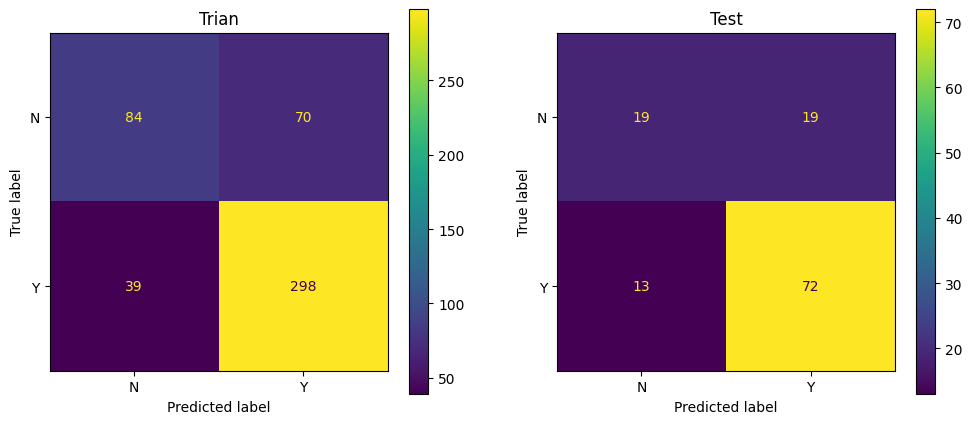

In [221]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Apply the preprocessor defined above
    ('smote', SMOTE()),  # Handle imbalanced classes using SMOTE
    ('classifier', LogisticRegression())  # Logistic Regression model
])

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

performance(pipeline)

## SVM

,accuracy,precision,recall,f1
trian,0.814664,0.920,0.448052,0.602620
test,0.788618,0.875,0.368421,0.518519


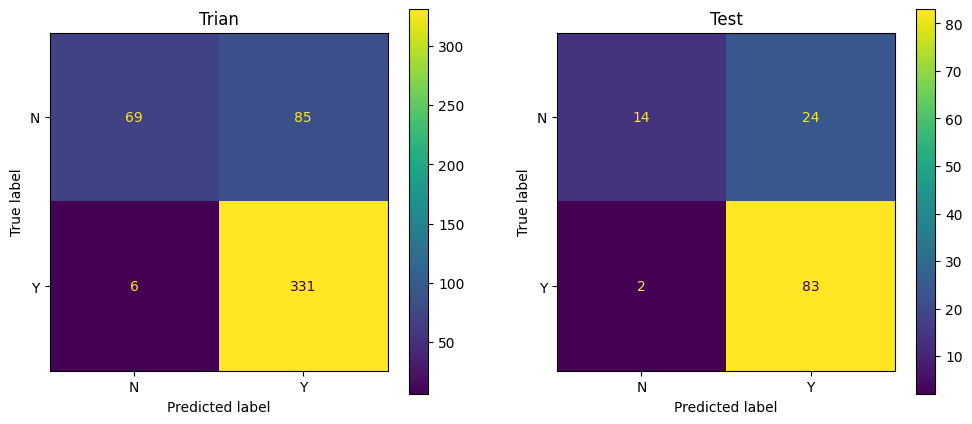

In [222]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Apply the preprocessor defined above
    ('smote', SMOTE()),  # Handle imbalanced classes using SMOTE
    ('classifier', SVC(kernel = 'linear')) 
])
# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

performance(pipeline)

,accuracy,precision,recall,f1
trian,0.804481,0.802083,0.500000,0.616000
test,0.747967,0.629630,0.447368,0.523077


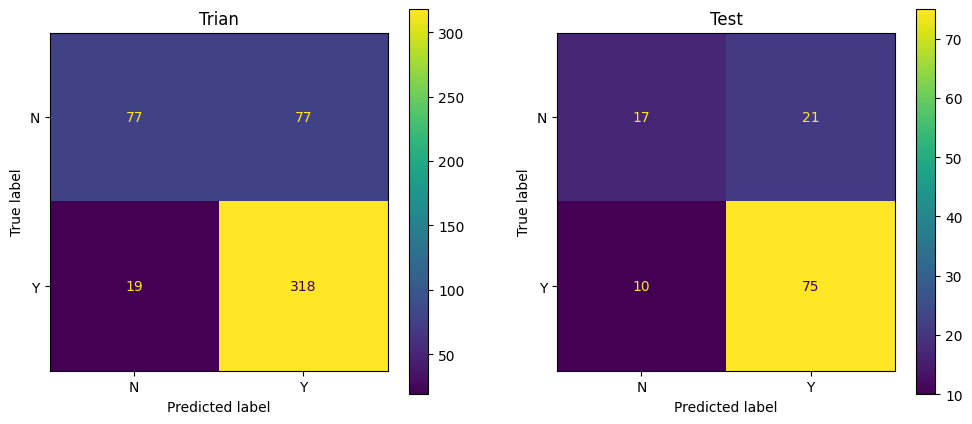

In [223]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Apply the preprocessor defined above
    ('smote', SMOTE()),  # Handle imbalanced classes using SMOTE
    ('classifier', LinearDiscriminantAnalysis(n_components=1)) 
])
# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

performance(pipeline)

,accuracy,precision,recall,f1
trian,0.853360,0.762821,0.772727,0.767742
test,0.634146,0.418605,0.473684,0.444444


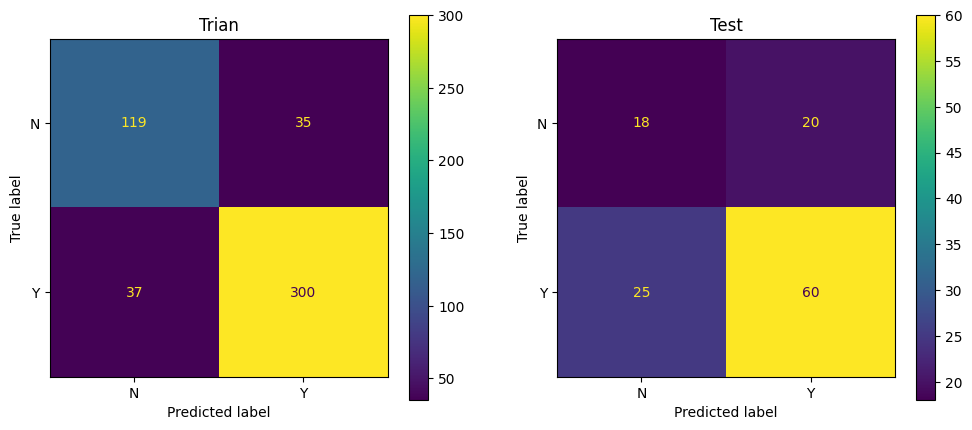

In [224]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Apply the preprocessor defined above
    #('oversampling', RandomOverSampler()),  # Handle imbalanced classes using SMOTE
    ('classifier', RandomForestClassifier(n_estimators= 1000, criterion = "gini", max_depth= 10, max_leaf_nodes=10, class_weight={"N":3, "Y":1})) 
])

pipeline.fit(X_train, y_train)

performance(pipeline)

In [225]:
22/(16+22)

0.5789473684210527

c:\Users\solmaz\anaconda3\envs\BigData\lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters found:  {'classifier__class_weight': {'N': 3, 'Y': 1}, 'classifier__criterion': 'entropy', 'classifier__max_depth': 12, 'classifier__max_leaf_nodes': 15}
Best cross-validation score: 0.7739


,accuracy,precision,recall,f1
trian,0.865580,0.785714,0.785714,0.785714
test,0.658537,0.450000,0.473684,0.461538


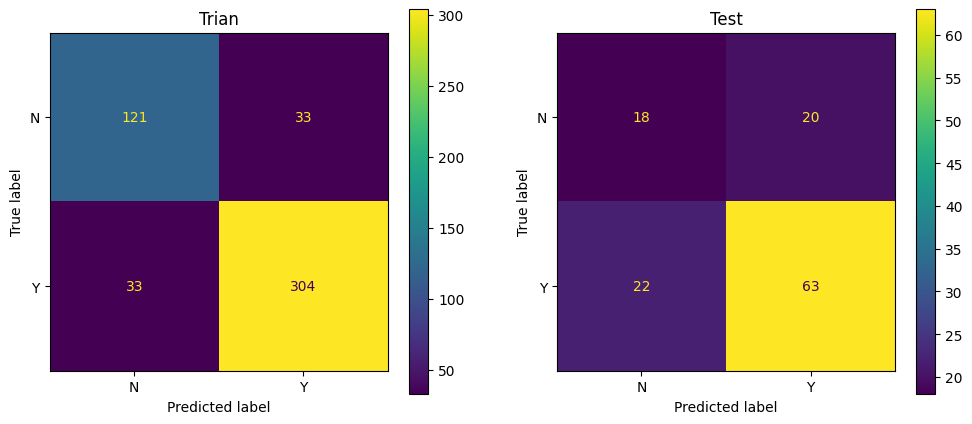

In [226]:


param_grid = {
    'classifier__criterion': ['gini', 'entropy'],            # Criterion for splitting
    'classifier__max_depth': [10,11,12,13 ],                   # Max depth of trees
    'classifier__max_leaf_nodes': [10, 12, 15],              # Max leaf nodes
    'classifier__class_weight': [{"N": 3, "Y": 1}, {"N": 5, "Y": 1}, {"N": 10, "Y": 1}]  # Class weights
}

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Apply the preprocessor defined above
    # ('smote', SMOTE()),  # Uncomment if needed for handling imbalanced classes
    ('classifier', RandomForestClassifier())  # You will tune the hyperparameters via GridSearchCV
])

# Set up the GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the grid search model to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and best estimator
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: {:.4f}".format(grid_search.best_score_))

# Use the best estimator to evaluate the performance on test data
best_pipeline = grid_search.best_estimator_
performance(best_pipeline)


,accuracy,precision,recall,f1
trian,0.869654,0.846154,0.714286,0.774648
test,0.715447,0.555556,0.394737,0.461538


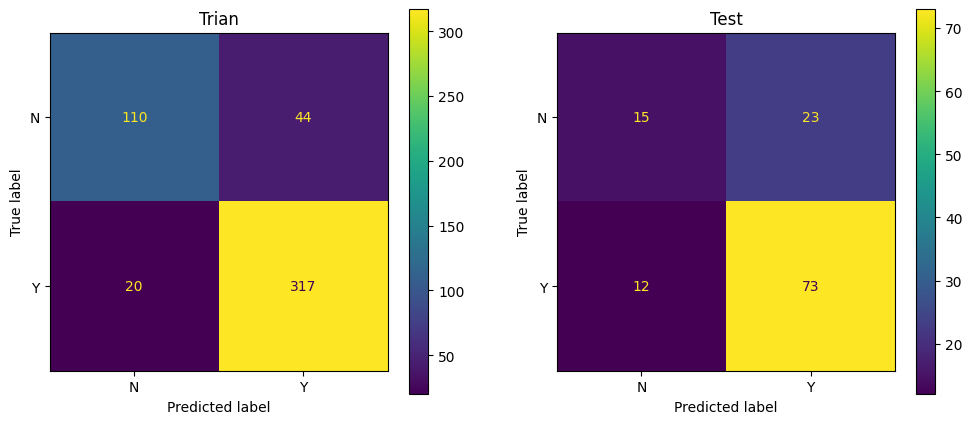

              Feature  Importance
5     ApplicantIncome    0.478519
8    Loan_Amount_Term    0.128262
9      Credit_History    0.113365
10      Property_Area    0.091185
1             Married    0.056405
7          LoanAmount    0.039658
4       Self_Employed    0.034615
2          Dependents    0.023411
6   CoapplicantIncome    0.021982
0              Gender    0.006476
3           Education    0.006121


In [234]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Apply the preprocessor defined above
    #('oversampling', RandomOverSampler()),  # Handle imbalanced classes using SMOTE
    ('classifier', RandomForestClassifier(n_estimators= 1000, criterion = "gini", max_depth= 10, max_leaf_nodes=10, class_weight={"N":2.5, "Y":1})) 
])

# Train the RandomForestClassifier
pipeline.fit(X_train, y_train)
performance(pipeline)
# Access the trained classifier
classifier = pipeline.named_steps['classifier']

# Get feature importances
importances = classifier.feature_importances_

feature_names = X_train.columns

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display the most important features
print(feature_importance_df)


In [230]:
importances

array([0.00952085, 0.05036376, 0.02906906, 0.00914961, 0.0373047 ,
       0.42457095, 0.02303657, 0.04210579, 0.14313797, 0.13110911,
       0.10063164])